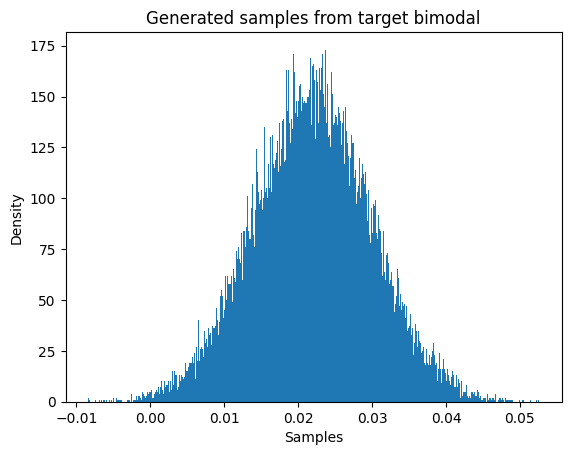

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

# generator
class Generator(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_feat, out_feat),
        )

    def forward(self, x):
        x = self.model(x)
        return x

# discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.model(x)
        return x

# training
lr = 0.001
num_epochs = 20000
batch_size = 64
input_size = 1
hidden_size = 16
output_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(input_size, output_size).to(device)
discriminator = Discriminator(input_size).to(device)

# loss/optimizers
loss_function = nn.BCELoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Generate samples from bimodal
def generate_samples(num_samples):
    mode1_samples = np.random.normal(loc=-2, scale=1, size=(num_samples // 2, 1))
    mode2_samples = np.random.normal(loc=2, scale=1, size=(num_samples // 2, 1))
    samples = np.concatenate([0.5*mode1_samples, 0.5*mode2_samples], axis=0)
    return samples

# Training loop
for epoch in range(num_epochs):
    # Generate real and fake samples
    real_samples = torch.Tensor(generate_samples(batch_size)).to(device)
    fake_samples = generator(torch.randn(batch_size, input_size).to(device))

    discriminator_optimizer.zero_grad()

    real_labels = torch.ones(batch_size, 1).to(device)
    real_predictions = discriminator(real_samples)
    real_loss = loss_function(real_predictions, real_labels)

    fake_labels = torch.zeros(batch_size, 1).to(device)
    fake_predictions = discriminator(fake_samples)
    fake_loss = loss_function(fake_predictions, fake_labels)

    discriminator_loss = real_loss + fake_loss
    discriminator_loss.backward()
    discriminator_optimizer.step()

    generator_optimizer.zero_grad()

    fake_samples = generator(torch.randn(batch_size, input_size).to(device))
    fake_predictions = discriminator(fake_samples)
    generator_loss = loss_function(fake_predictions, real_labels)

    # generator weights
    generator_loss.backward()
    generator_optimizer.step()


# Generate samples from the learned distribution
num_samples = 25000
with torch.no_grad():
    noise = torch.randn(num_samples, input_size).to(device)
    generated_samples = generator(noise).cpu().numpy()

# visualize
plt.hist(generated_samples, bins=500)
plt.xlabel('Samples')
plt.ylabel('Density')
plt.title('Generated samples from target bimodal')
plt.show()

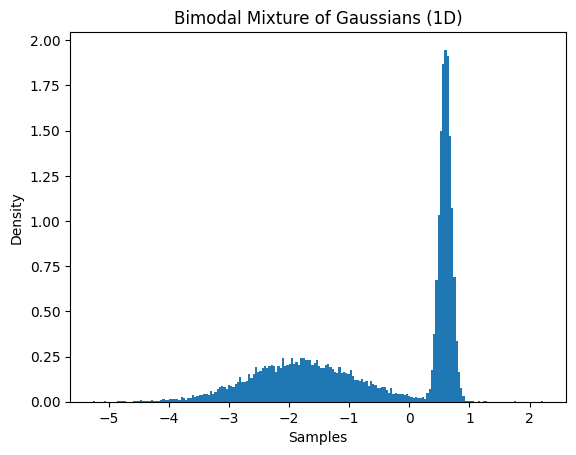

In [2]:
np.random.seed(42)
mix = 0.1

# Generate samples from the two Gaussian distributions
mode1_samples = np.random.normal(6, 1, size=(10000,))
mode2_samples = np.random.normal(-2, 1, size=(10000,))

# Combine the samples according to the mixing ratio
bimodal_samples = np.concatenate([
     mix * mode1_samples,
    (1 - mix) * mode2_samples
])

# Plot a histogram of the bimodal mixture
plt.hist(bimodal_samples, bins=200, density=True)
plt.xlabel('Samples')
plt.ylabel('Density')
plt.title('Bimodal Mixture of Gaussians (1D)')
plt.show()